In [1]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries,make_distance_graph
import numpy as np

Cluster 0 done


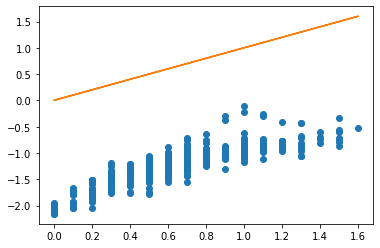

Cluster 1 done


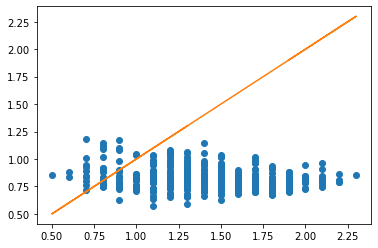

Cluster 2 done


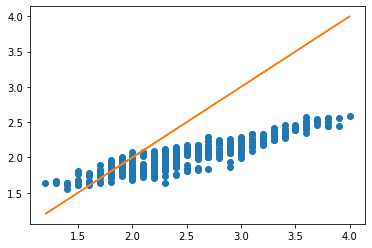

Cluster 3 done


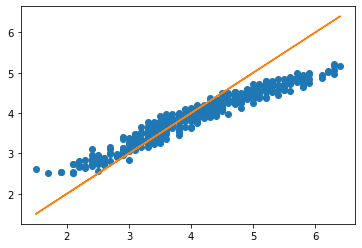

Cluster 4 done


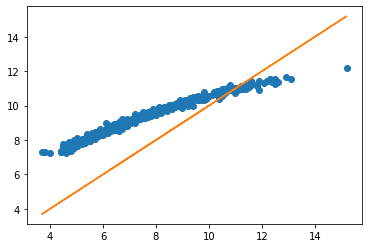

Cluster 5 done


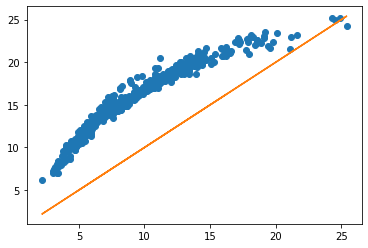

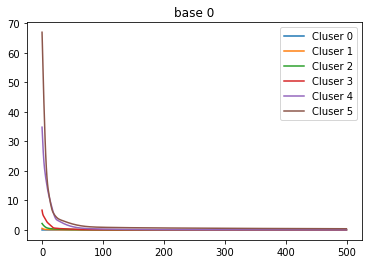

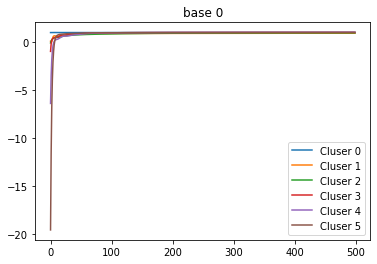

Cluster 0 done


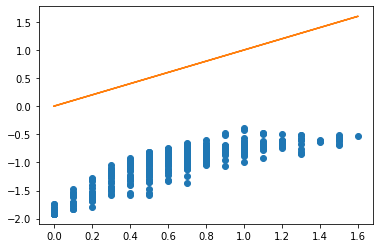

KeyboardInterrupt: 

In [19]:
import warnings
warnings.filterwarnings('ignore')
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,0,0,0,0,1]
#make clusters the same size with a random sample
resize=True
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
#
# parameters for neural net
epochs = 500
resolution=500
batch_size = 128
input_size = 5
output_size = 1
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#Base Cluster for transfer learning 
#specify cluster
meta_trials=100
meta=[]
for seed,i in enumerate(range(meta_trials)):
    np.random.seed(seed)
    torch.manual_seed(seed)
    #create holder for meta anaylsis
    mega={}
    if resize:
        M_Cluster=size_clusters(O_M_Cluster)
    else:
        M_Cluster=O_M_Cluster
    for i in range(len(M_Cluster)):
        mega[i]=[]
    for count,g in enumerate(M_Cluster):
        cluster=count
        data = g
        #checks for index problem
        data = data.reset_index(drop=True)
        #computer requirements 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #gpu not supported, problem with r2 plug in never solved
        device=torch.device("cpu")
        base_path = os.getcwd()

        features = [
            "void fraction",
            "Vol. S.A.",
            "Grav. S.A.",
            "Pore diameter Limiting",
            "Pore diameter Largest",
        ]
        #create splits 
        df_train,df_val,df_test=prep_data_splits(data,features,interest)
        #create dataset loader objects for looping through data,default test size is .2
        first = MyDataset(df_train, interest, features)
        train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

        second = MyDataset(df_val, interest, features)
        val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

        third = MyDataset(df_test, interest, features)
        test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
        #intialize holders for data
        train_loss = []
        train_r_2 = []
        val_loss = []
        val_r_2 = []
        test_loss = []
        test_r_2 = []
        net_time = []

        # initalize model
        model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
        criterion = nn.MSELoss()
        learning_rate = trial_parameters["lr"]
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        #Create engine for running NN, pytorch

        def train_step(engine, batch):
            x, y = batch
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            return loss.item()

        trainer = Engine(train_step)
        #sets up loss and R scores and stores values
        #Note: note sure if can condense this into a module b/c of decorator and namespace
        @trainer.on(Events.EPOCH_COMPLETED(every=50))
        def store_metrics(engine):
            end = time.time()
            e = engine.state.epoch
            out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
            out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
            out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
            out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
            out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
            out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
            train_loss.append(out)
            train_r_2.append(out1)
            val_loss.append(out2)
            val_r_2.append(out3)
            test_loss.append(out4)
            test_r_2.append(out5)
            net_time.append(end-start)
            if loud[2]:
                print(e)
        #Creates timer and runs trainer 
        start = time.time()
        trainer.logger.disabled=True
        trainer.run(train_loader, max_epochs=epochs)
        plt.show()

        if loud[3]:
            plt.plot(val_r_2)
            plt.plot(train_r_2,label="t")
            plt.plot(test_r_2,label="real")
            plt.legend()
            plt.show()
            plt.plot(val_loss)
            plt.plot(train_loss,label="t")
            plt.plot(test_loss,label="real")
            plt.legend()
            plt.show()
        #save base model for transfer into other clusters in loop
        torch.save(model, "Temp2.ckpt")
        #transfer learning part
        #stores meta data
        test_loss_holder=[]
        test_r2_holder=[]
        #loops through clusters
        for count,i in enumerate(M_Cluster):
            train_loss = []
            train_r_2 = []
            val_loss = []
            val_r_2 = []
            test_loss = []
            test_r_2 = []
            net_time = []
            #loading model again
            model=torch.load("Temp2.ckpt")
            descriptor_columns = [
                "void fraction",
                "Vol. S.A.",
                "Grav. S.A.",
                "Pore diameter Limiting",
                "Pore diameter Largest",
            ]
        #turns off model learning
            model.fc1.weight.requires_grad = False
            model.fc1.bias.requires_grad = False
            model.fc2.weight.requires_grad = False
            model.fc2.bias.requires_grad = False

            optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
            )
            #Base Cluster for transfer learning 
            data = i
            #checks for index problem
            data = data.reset_index(drop=True)
            df_train,df_val,df_test=prep_data_splits(data,features,interest)
            #create dataset loader objects for looping through data,default test size is .2
            first = MyDataset(df_train, interest, features)
            train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

            second = MyDataset(df_val, interest, features)
            val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

            third = MyDataset(df_test, interest, features)
            test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

            #once again making training and testing engine
            def train_step_1(engine, batch):
                x, y = batch
                model.train()
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                return loss.item()


            transfer_trainer = Engine(train_step_1)
            n=int(epochs/resolution)
            @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
            def store_metrics(engine):
                end = time.time()
                e = engine.state.epoch
                out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
                out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
                out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
                out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
                out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
                out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
                train_loss.append(out)
                train_r_2.append(out1)
                val_loss.append(out2)
                val_r_2.append(out3)
                test_loss.append(out4)
                test_r_2.append(out5)
                net_time.append(end-start)
                if loud[4]:
                    print(e)
            #runs model
            transfer_trainer.logger.disabled=True
            transfer_trainer.run(train_loader, max_epochs=epochs)
            test_loss_holder.append(test_loss)
            test_r2_holder.append(test_r_2)
            print(f"Cluster {count} done")
            v=torch.tensor(data[features].values.astype(np.float32))
            results=model(v)
            r_1=np.array(data[interest].astype(np.float32))
            plt.plot(r_1,results.detach().numpy(),'o')
            plt.plot(r_1,r_1)
            plt.show()
        #because error tends to be low, only anaylizing r2 scores
            mega[count].append(test_r_2)
        #plots all clusers learning in terms of test set
        if loud[5]:
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_loss_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
            plt.show()
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_r2_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
    meta.append(mega)
    print(seed)

In [21]:
model(v)

tensor([[0.4205],
        [0.5394],
        [0.5123],
        [0.5372],
        [0.5775],
        [0.4379],
        [0.4712],
        [0.4882],
        [0.5665],
        [0.5260],
        [0.5395],
        [0.4325],
        [0.4817],
        [0.5230],
        [0.5728],
        [0.5372],
        [0.5307],
        [0.5932],
        [0.6404],
        [0.5536],
        [0.4412],
        [0.6045],
        [0.5029],
        [0.4457],
        [0.4517],
        [0.4191],
        [0.5719],
        [0.6107],
        [0.4686],
        [0.6652],
        [0.5236],
        [0.5665],
        [0.5996],
        [0.3793],
        [0.5795],
        [0.6371],
        [0.4948],
        [0.6997],
        [0.4599],
        [0.5114],
        [0.4207],
        [0.4897],
        [0.5482],
        [0.5410],
        [0.5507],
        [0.6066],
        [0.4570],
        [0.5019],
        [0.5956],
        [0.6078],
        [0.4373],
        [0.6960],
        [0.5324],
        [0.4926],
        [0.5199],
        [0

In [17]:
r_1

NameError: name 'r_1' is not defined

In [4]:
import json
epoch_conversions=[]
byte=df_train.iloc[0].memory_usage()
for i in M_Cluster:
    epoch_conversions.append(len(i))
outs=[epoch_conversions,byte,epochs,resolution]
o_name=["epoch_conversions","byte","epochs","resolution"]
for a,b in zip(outs,o_name):
    print(f"Variable {b} is {a}")
with open('data.json', 'w') as f:
    json.dump(meta, f)

Variable epoch_conversions is [431, 431, 431, 431, 431, 431]
Variable byte is 268
Variable epochs is 500
Variable resolution is 500


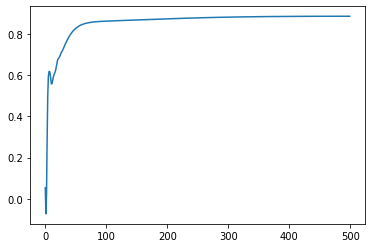

In [6]:
plt.plot(mega[1][0])

In [25]:
float(criterion(val_loader.dataset.y_train,model(val_loader.dataset.x_train)))

0.0024274769239127636

In [26]:
count

1

Cluster 0 - 0 done


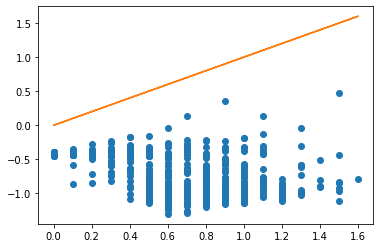

Cluster 0 - 0 done


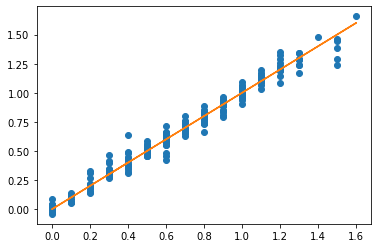

KeyboardInterrupt: 

In [44]:
for count,g in enumerate(M_Cluster):
    cluster=count
    data = g
    #checks for index problem
    data = data.reset_index(drop=True)
    #computer requirements 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #gpu not supported, problem with r2 plug in never solved
    device=torch.device("cpu")
    base_path = os.getcwd()

    features = [
        "void fraction",
        "Vol. S.A.",
        "Grav. S.A.",
        "Pore diameter Limiting",
        "Pore diameter Largest",
    ]
    #create splits 
    df_train,df_val,df_test=prep_data_splits(data,features,interest)
    #create dataset loader objects for looping through data,default test size is .2
    first = MyDataset(df_train, interest, features)
    train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

    second = MyDataset(df_val, interest, features)
    val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

    third = MyDataset(df_test, interest, features)
    test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
    #intialize holders for data
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []

    # initalize model
    model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
    criterion = nn.MSELoss()
    learning_rate = trial_parameters["lr"]
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #Create engine for running NN, pytorch

    def train_step(engine, batch):
        x, y = batch
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        return loss.item()

    trainer = Engine(train_step)
    #sets up loss and R scores and stores values
    #Note: note sure if can condense this into a module b/c of decorator and namespace
    @trainer.on(Events.EPOCH_COMPLETED(every=50))
    def store_metrics(engine):
        end = time.time()
        e = engine.state.epoch
        out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
        out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
        out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
        out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
        out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
        out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
        train_loss.append(out)
        train_r_2.append(out1)
        val_loss.append(out2)
        val_r_2.append(out3)
        test_loss.append(out4)
        test_r_2.append(out5)
        net_time.append(end-start)
        if loud[2]:
            print(e)
    #Creates timer and runs trainer 
    start = time.time()
    trainer.logger.disabled=True
    trainer.run(train_loader, max_epochs=epochs)
    plt.show()

    if loud[3]:
        plt.plot(val_r_2)
        plt.plot(train_r_2,label="t")
        plt.plot(test_r_2,label="real")
        plt.legend()
        plt.show()
        plt.plot(val_loss)
        plt.plot(train_loss,label="t")
        plt.plot(test_loss,label="real")
        plt.legend()
        plt.show()
    #save base model for transfer into other clusters in loop
    torch.save(model, "Temp2.ckpt")
    #transfer learning part
    #stores meta data
    test_loss_holder=[]
    test_r2_holder=[]
    #loops through clusters
    for count,i in enumerate(M_Cluster):
        train_loss = []
        train_r_2 = []
        val_loss = []
        val_r_2 = []
        test_loss = []
        test_r_2 = []
        net_time = []
        #loading model again
        model=torch.load("Temp2.ckpt")
        descriptor_columns = [
            "void fraction",
            "Vol. S.A.",
            "Grav. S.A.",
            "Pore diameter Limiting",
            "Pore diameter Largest",
        ]
    #turns off model learning
        model.fc1.weight.requires_grad = False
        model.fc1.bias.requires_grad = False
        model.fc2.weight.requires_grad = False
        model.fc2.bias.requires_grad = False

        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
        )
        #Base Cluster for transfer learning 
        data = i
        #checks for index problem
        data = data.reset_index(drop=True)
        df_train,df_val,df_test=prep_data_splits(data,features,interest)
        #create dataset loader objects for looping through data,default test size is .2
        first = MyDataset(df_train, interest, features)
        train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

        second = MyDataset(df_val, interest, features)
        val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

        third = MyDataset(df_test, interest, features)
        test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

        #once again making training and testing engine
        def train_step_1(engine, batch):
            x, y = batch
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            return loss.item()


        transfer_trainer = Engine(train_step_1)
        n=int(epochs/resolution)
        @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
        def store_metrics(engine):
            end = time.time()
            e = engine.state.epoch
            out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
            out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
            out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
            out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
            out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
            out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
            train_loss.append(out)
            train_r_2.append(out1)
            val_loss.append(out2)
            val_r_2.append(out3)
            test_loss.append(out4)
            test_r_2.append(out5)
            net_time.append(end-start)
            if loud[4]:
                print(e)
        #runs model
        transfer_trainer.logger.disabled=True
        transfer_trainer.run(train_loader, max_epochs=epochs)
        test_loss_holder.append(test_loss)
        test_r2_holder.append(test_r_2)
        print(f"Cluster {cluster} - {count} done")
        v=torch.tensor(data[features].values.astype(np.float32))
        results=model(v)
        r_1=np.array(data[interest].astype(np.float32))
        plt.plot(r_1,results.detach().numpy(),'o')
        plt.plot(r_1,r_1)
        plt.show()
        print(f"Cluster {cluster} - {count} done")
        v=torch.tensor(train_loader.dataset.x_train)
        results=model(v)
        r_1=np.array(data[interest].astype(np.float32))
        plt.plot(train_loader.dataset.y_train,results.detach().numpy(),'o')
        plt.plot(train_loader.dataset.y_train,train_loader.dataset.y_train)
        plt.show()

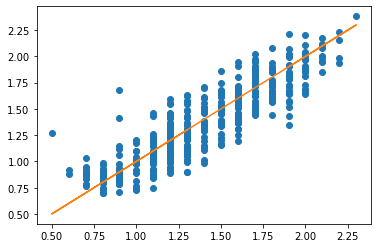

Cluster 0 - 1 done


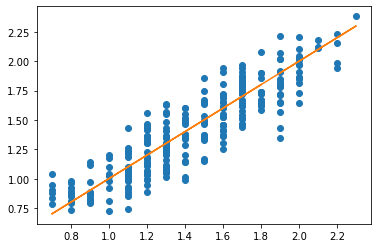

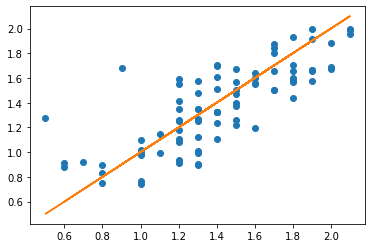

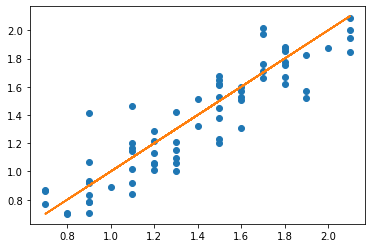

In [68]:
#minmax scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
a=StandardScaler().fit_transform(data[features].values.astype(np.float32))
a=torch.tensor(a)
results=model(a)
r_1=np.array(data[interest].astype(np.float32))
plt.plot(r_1,results.detach().numpy(),'o')
plt.plot(r_1,r_1)
plt.show()
print(f"Cluster {cluster} - {count} done")
v=torch.tensor(train_loader.dataset.x_train)
results=model(v)
r_1=np.array(data[interest].astype(np.float32))
plt.plot(train_loader.dataset.y_train,results.detach().numpy(),'o')
plt.plot(train_loader.dataset.y_train,train_loader.dataset.y_train)
plt.show()
v=torch.tensor(test_loader.dataset.x_train)
results=model(v)
r_1=np.array(data[interest].astype(np.float32))
plt.plot(test_loader.dataset.y_train,results.detach().numpy(),'o')
plt.plot(test_loader.dataset.y_train,test_loader.dataset.y_train)
plt.show()
v=torch.tensor(val_loader.dataset.x_train)
results=model(v)
r_1=np.array(data[interest].astype(np.float32))
plt.plot(val_loader.dataset.y_train,results.detach().numpy(),'o')
plt.plot(val_loader.dataset.y_train,val_loader.dataset.y_train)
plt.show()

In [62]:
data[features]

,void fraction,Vol. S.A.,Grav. S.A.,Pore diameter Limiting,Pore diameter Largest
0,-0.987937,0.796553,-1.574021,-0.735854,-1.044238
1,-1.481282,0.200628,-1.794802,-0.745280,-0.653477
2,-1.399058,1.621023,-1.263400,-1.197759,-1.489704
3,-1.399058,1.134031,-1.230426,-1.339158,-1.356846
4,-0.659041,0.418493,-1.365188,-0.500188,-0.387760
...,...,...,...,...,...
426,-0.823489,0.414222,-1.562074,-0.613308,-0.583140
427,-1.645730,0.345872,-1.673898,-1.386291,-1.434998
428,-1.645730,0.113055,-1.839723,-1.395718,-0.989531
429,-1.399058,1.561217,-1.376179,-1.273172,-1.528781
